In [1]:
from calibration_config import *
from tti_models.analyzers.alternative_fit import FitGrowthRate
from tti_models.infectiousness_profiles import FerrettiInfectionDynamics
import covasim as cv
from contact_matrices import contact_scenarios
from functools import partial
import seaborn as sns 
from scipy.optimize import minimize_scalar
import statsmodels.api as sm
from patsy import dmatrices
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
sns.set()

Covasim 3.0.2 (2021-04-26) — © 2021 by IDM


In [2]:
# calibration wide settings
# because I keep changing things
starting_infections = 100
contact_scenario = 'Polymod'
pop_size = 100000

short_simulation_time = 60 # no need to run full simulations to estimate growth rates
full_simulation_time = 180 # used to assess full epidemics 

## Model Calibration Notebook
We aim to simulate growing epidemics for all interventions, for two different contact scenarios: July2020, and March2021.

Initially, we focus on finding an upper and lower bound for beta. This is achieved by plotting sample epidemics, and finding time periods where we can conistently estimate the gorwth rate of the epidemic without significant suscpeitble depletion.

In [3]:
def run_simulation(beta: float, starting_infections: int, contact_scenario: str, pop_size: float, n_days: int, rand_seed: int):
    """Runs a simulation for a trial and returns a growth rate object

    Args:
        beta (float): trial 
        starting_infections (int): [description]
        contact_scenario (str): [description]
        pop_size (float): population size to trial

    Returns:
        FitGrowthRate: simulation growth rate analyzer object
    """

    ferretti_infectiousness = FerrettiInfectionDynamics()

    input_pars = copy(sim_pars)
    input_pars['pop_size'] = pop_size
    input_pars['beta'] = beta
    input_pars['n_days'] = n_days
    input_pars['rand_seed'] = rand_seed

    sim = cv.Sim(input_pars,
                pop_infected = starting_infections,
                infection_dynamics = ferretti_infectiousness,
                contact_matrices = contact_scenarios[contact_scenario],
                verbose = 0)

    sim.run()

    # pass to the objective function to evaluate the mismatch
    return FitGrowthRate(sim, growth_rate=0.0)

## Finding an appropiate upper bound

In [43]:
samples = [
    run_simulation(beta = 1.5, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=short_simulation_time, rand_seed=_)
    for _ in range(5)
]

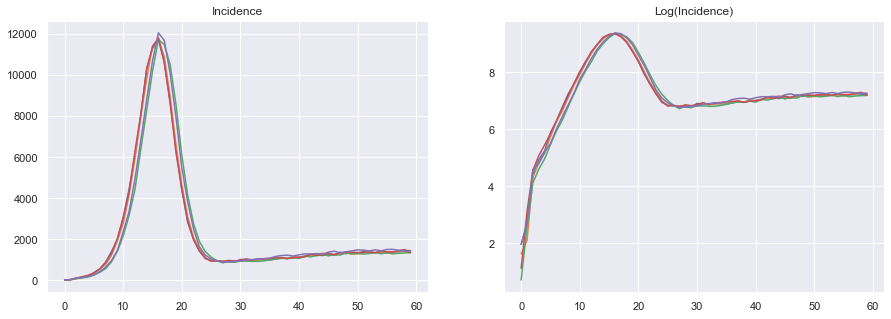

In [44]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = short_simulation_time

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

Inspection of the plots suggest that the growth rate is practically constant from day 10 to 30. Afterwards, there is slight susceptible depletion which becomes quite severe around days 40. We estimate the growth rate using days 10 to 30.

In [45]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

growth_rates

[0.3116919236593964,
 0.3191816683563363,
 0.33640647593136486,
 0.3145834688775644,
 0.3353744435949295]

In [46]:
np.mean(growth_rates)

0.3234475960839183

## Finding an appropiate lower bound

In [59]:
samples = [
    run_simulation(beta = 0.125, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=short_simulation_time, rand_seed=_)
    for _ in range(5)
]

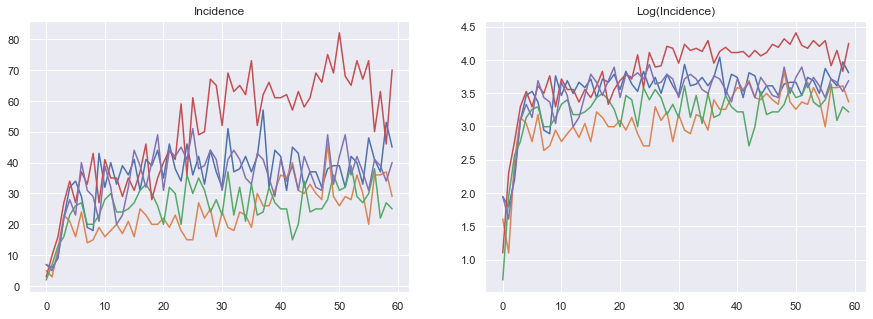

In [60]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = 60

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

Inspection of the plots suggest that the growth rate is practically constant from day 10 to 60. Afterwards, there is slight susceptible depletion which becomes quite severe around days 40. We estimate the growth rate using days 10 to 30, to be constisent with the upper bound.

In [61]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

growth_rates

[0.03606673199323029,
 0.009698865214463549,
 0.005521144724303897,
 0.0025518686616488734,
 -0.0124177706858929]

In [62]:
np.mean(growth_rates)

0.008284167981550742

## Finding calibrated parameters
We estimate the growth rate over a grid of values, then fit a linear model. This is a pretty efficicient method when there's only a single parameter to calibrate, however it will rapidly lose efficiency as the number of parameters to calibrate increases, at which point a BayesOpt approach is more suitable.

In [71]:
search_space = np.linspace(0.125, 2.5, 50)

samples = [
    run_simulation(beta = beta, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=25, rand_seed=seed)
    for seed, beta in enumerate(search_space)
]

In [72]:
for epidemic in samples:
    epidemic.estimate_growth_rate(day_from=5, day_to=15)

growth_rates = [epidemic.estimated_growth_rate for epidemic in samples]

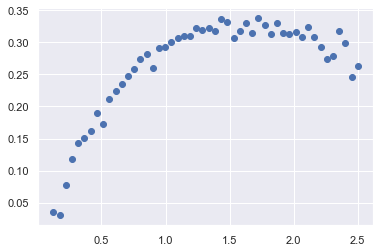

In [73]:
plt.scatter(search_space, growth_rates)
plt.show()

In [74]:
data = pd.DataFrame({'growth_rate': growth_rates, 'beta': search_space})

In [75]:
y, X = dmatrices('growth_rate ~ beta + I(beta**2) + I(beta**3)', data = data, return_type='dataframe')
mod_2 = sm.RLM(y, X)
res_2 = mod_2.fit()
print(res_2.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:            growth_rate   No. Observations:                   50
Model:                            RLM   Df Residuals:                       46
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 04 Mar 2022                                         
Time:                        23:20:34                                         
No. Iterations:                    25                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0217      0.009     -2.428   

Model selection suggest no quadratic component, we opt for linear regression model when estimating calibration values.

In [76]:
intercept = res_2.params['Intercept']
beta_coef = res_2.params['beta']
beta_coef_2 = res_2.params['I(beta ** 2)']
beta_coef_3 = res_2.params['I(beta ** 3)']

def estimate_growth_rate(beta):
    return intercept + beta_coef * beta + beta_coef_2 * beta**2 + beta_coef_3 * beta ** 3 

def objective_fun(beta, target_growth_rate):
    return abs(target_growth_rate - estimate_growth_rate(beta))

def get_calibrated_beta(target_growth_rate):
    objective_partial = partial(objective_fun, target_growth_rate = target_growth_rate)
    res = minimize_scalar(objective_partial, bracket = [1, 10])
    return round(res.x, 3)

In [77]:
target_growth_rates = [0.025, 0.05, 0.1, 0.15, 0.225, 0.3]
calibration_dict = {growth_rate:get_calibrated_beta(growth_rate) for growth_rate in target_growth_rates}

In [78]:
calibration_dict

{0.025: 3.274, 0.05: 3.274, 0.1: 3.274, 0.15: 3.274, 0.225: 3.274, 0.3: 1.024}

In [70]:
calibration_dict

{0.025: 0.139, 0.05: 0.181, 0.1: 0.276, 0.15: 0.387, 0.225: 0.609, 0.3: 1.049}

In [43]:
{0.15: 0.709, 0.225: 1.26, 0.3: 2.441}

{0.15: 0.709, 0.225: 1.26, 0.3: 2.441}

## Trialing configured epidemic 
We try one of the scenarios with the most interventions to see if we still achieve a growing epidemic. If we don't have a growing epidemic, then it's much harder to infer the effectiveness of the interventions.

In [63]:
def run_simulation_with_interventions(beta: float, starting_infections: int, contact_scenario: str, pop_size: float, n_days: int, rand_seed: int):
    """Runs a simulation for a trial and returns a growth rate object

    Args:
        beta (float): trial 
        starting_infections (int): [description]
        contact_scenario (str): [description]
        pop_size (float): population size to trial

    Returns:
        FitGrowthRate: simulation growth rate analyzer object
    """

    ferretti_infectiousness = FerrettiInfectionDynamics()
    testing = testing_intervs[0.01]
    interventions = [testing, ili_ST_iso, pcr_symptomatic_testing, AZ_high, pfizer_high, dct]

    input_pars = copy(sim_pars)
    input_pars['pop_size'] = pop_size
    input_pars['beta'] = beta
    input_pars['n_days'] = n_days
    input_pars['rand_seed'] = rand_seed

    sim = cv.Sim(input_pars,
                pop_infected = starting_infections,
                interventions = interventions,
                infection_dynamics = ferretti_infectiousness,
                contact_matrices = contact_scenarios[contact_scenario],
                verbose = 0)

    sim.run()

    # pass to the objective function to evaluate the mismatch
    return FitGrowthRate(sim, growth_rate=0.0)

In [29]:
samples = [
    run_simulation_with_interventions(beta = 0.242, starting_infections=starting_infections, contact_scenario=contact_scenario, pop_size=pop_size, n_days=180, rand_seed=_)
    for _ in range(5)
]

0 h 100291 100291 100291
0 s 99817 99817 99817
0 w 134722 134722 134722
0 c 249860 249860 249860
1 h 100291 100291 100291
1 s 99817 99817 99817
1 w 134722 134722 134722
1 c 249860 249860 249860
2 h 100291 100291 100291
2 s 99817 99817 99817
2 w 134722 134722 134722
2 c 249860 249860 249860
3 h 100291 100291 100291
3 s 99817 99817 99817
3 w 134722 134722 134722
3 c 249860 249860 249860
4 h 100291 100291 100291
4 s 99817 99817 99817
4 w 134722 134722 134722
4 c 249860 249860 249860
5 h 100291 100291 100291
5 s 99817 99817 99817
5 w 134722 134722 134722
5 c 249860 249860 249860
6 h 100291 100291 100291
6 s 99817 99817 99817
6 w 134722 134722 134722
6 c 249860 249860 249860
7 h 100291 100291 100291
7 s 99817 99817 99817
7 w 134722 134722 134722
7 c 249860 249860 249860
8 h 100291 100291 100291
8 s 99817 99817 99817
8 w 134722 134722 134722
8 c 249860 249860 249860
9 h 100291 100291 100291
9 s 99817 99817 99817
9 w 134722 134722 134722
9 c 249860 249860 249860
10 h 100291 100291 100291
10 s

160 h 100291 100291 100291
160 s 99817 99817 99817
160 w 134722 134722 134722
160 c 249860 249860 249860
161 h 100291 100291 100291
161 s 99817 99817 99817
161 w 134722 134722 134722
161 c 249860 249860 249860
162 h 100291 100291 100291
162 s 99817 99817 99817
162 w 134722 134722 134722
162 c 249860 249860 249860
163 h 100291 100291 100291
163 s 99817 99817 99817
163 w 134722 134722 134722
163 c 249860 249860 249860
164 h 100291 100291 100291
164 s 99817 99817 99817
164 w 134722 134722 134722
164 c 249860 249860 249860
165 h 100291 100291 100291
165 s 99817 99817 99817
165 w 134722 134722 134722
165 c 249860 249860 249860
166 h 100291 100291 100291
166 s 99817 99817 99817
166 w 134722 134722 134722
166 c 249860 249860 249860
167 h 100291 100291 100291
167 s 99817 99817 99817
167 w 134722 134722 134722
167 c 249860 249860 249860
168 h 100291 100291 100291
168 s 99817 99817 99817
168 w 134722 134722 134722
168 c 249860 249860 249860
169 h 100291 100291 100291
169 s 99817 99817 99817
169 

143 s 98848 98848 98848
143 w 134198 134198 134198
143 c 250675 250675 250675
144 h 99641 99641 99641
144 s 98848 98848 98848
144 w 134198 134198 134198
144 c 250675 250675 250675
145 h 99641 99641 99641
145 s 98848 98848 98848
145 w 134198 134198 134198
145 c 250675 250675 250675
146 h 99641 99641 99641
146 s 98848 98848 98848
146 w 134198 134198 134198
146 c 250675 250675 250675
147 h 99641 99641 99641
147 s 98848 98848 98848
147 w 134198 134198 134198
147 c 250675 250675 250675
148 h 99641 99641 99641
148 s 98848 98848 98848
148 w 134198 134198 134198
148 c 250675 250675 250675
149 h 99641 99641 99641
149 s 98848 98848 98848
149 w 134198 134198 134198
149 c 250675 250675 250675
150 h 99641 99641 99641
150 s 98848 98848 98848
150 w 134198 134198 134198
150 c 250675 250675 250675
151 h 99641 99641 99641
151 s 98848 98848 98848
151 w 134198 134198 134198
151 c 250675 250675 250675
152 h 99641 99641 99641
152 s 98848 98848 98848
152 w 134198 134198 134198
152 c 250675 250675 250675
153 

123 s 100811 100811 100811
123 w 132224 132224 132224
123 c 250383 250383 250383
124 h 99148 99148 99148
124 s 100811 100811 100811
124 w 132224 132224 132224
124 c 250383 250383 250383
125 h 99148 99148 99148
125 s 100811 100811 100811
125 w 132224 132224 132224
125 c 250383 250383 250383
126 h 99148 99148 99148
126 s 100811 100811 100811
126 w 132224 132224 132224
126 c 250383 250383 250383
127 h 99148 99148 99148
127 s 100811 100811 100811
127 w 132224 132224 132224
127 c 250383 250383 250383
128 h 99148 99148 99148
128 s 100811 100811 100811
128 w 132224 132224 132224
128 c 250383 250383 250383
129 h 99148 99148 99148
129 s 100811 100811 100811
129 w 132224 132224 132224
129 c 250383 250383 250383
130 h 99148 99148 99148
130 s 100811 100811 100811
130 w 132224 132224 132224
130 c 250383 250383 250383
131 h 99148 99148 99148
131 s 100811 100811 100811
131 w 132224 132224 132224
131 c 250383 250383 250383
132 h 99148 99148 99148
132 s 100811 100811 100811
132 w 132224 132224 132224
1

99 w 134051 134051 134051
99 c 250875 250875 250875
100 h 100292 100292 100292
100 s 100367 100367 100367
100 w 134051 134051 134051
100 c 250875 250875 250875
101 h 100292 100292 100292
101 s 100367 100367 100367
101 w 134051 134051 134051
101 c 250875 250875 250875
102 h 100292 100292 100292
102 s 100367 100367 100367
102 w 134051 134051 134051
102 c 250875 250875 250875
103 h 100292 100292 100292
103 s 100367 100367 100367
103 w 134051 134051 134051
103 c 250875 250875 250875
104 h 100292 100292 100292
104 s 100367 100367 100367
104 w 134051 134051 134051
104 c 250875 250875 250875
105 h 100292 100292 100292
105 s 100367 100367 100367
105 w 134051 134051 134051
105 c 250875 250875 250875
106 h 100292 100292 100292
106 s 100367 100367 100367
106 w 134051 134051 134051
106 c 250875 250875 250875
107 h 100292 100292 100292
107 s 100367 100367 100367
107 w 134051 134051 134051
107 c 250875 250875 250875
108 h 100292 100292 100292
108 s 100367 100367 100367
108 w 134051 134051 134051
108

73 h 100313 100313 100313
73 s 102338 102338 102338
73 w 134748 134748 134748
73 c 251069 251069 251069
74 h 100313 100313 100313
74 s 102338 102338 102338
74 w 134748 134748 134748
74 c 251069 251069 251069
75 h 100313 100313 100313
75 s 102338 102338 102338
75 w 134748 134748 134748
75 c 251069 251069 251069
76 h 100313 100313 100313
76 s 102338 102338 102338
76 w 134748 134748 134748
76 c 251069 251069 251069
77 h 100313 100313 100313
77 s 102338 102338 102338
77 w 134748 134748 134748
77 c 251069 251069 251069
78 h 100313 100313 100313
78 s 102338 102338 102338
78 w 134748 134748 134748
78 c 251069 251069 251069
79 h 100313 100313 100313
79 s 102338 102338 102338
79 w 134748 134748 134748
79 c 251069 251069 251069
80 h 100313 100313 100313
80 s 102338 102338 102338
80 w 134748 134748 134748
80 c 251069 251069 251069
81 h 100313 100313 100313
81 s 102338 102338 102338
81 w 134748 134748 134748
81 c 251069 251069 251069
82 h 100313 100313 100313
82 s 102338 102338 102338
82 w 134748 

In [ ]:
fig, axs= plt.subplots(nrows=1, ncols=2, figsize = (15, 5))

axs[0].set_title('Incidence')
axs[1].set_title('Log(Incidence)')

n_days = 180

for epidemic in samples:

    cases = epidemic.get_cases(day_from=0, day_to=n_days)

    axs[0].plot(range(len(cases)), cases)
    axs[1].plot(range(len(cases)), np.log(cases))

plt.show()

In [122]:
beta_calibrated

0.4145725607384752